# ICS 635 - Assignment 4
> Derek Garcia

## Load and Normalize FashionMNIST

In [1]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms

# Download training data
fashion_train_data = datasets.FashionMNIST(
    root='./data',  # save images to ./data
    train=True,     # training data
    download=True,  # download locally
    transform=transforms.ToTensor()     # Normalize the images to the range [0,1]
)
# split into 80/20 testing and validation
size = len(fashion_train_data)
train_size = int(0.8 * size)
validation_size = size - train_size
train, validation = random_split(fashion_train_data, [train_size, validation_size])

# download the testing data
test = datasets.FashionMNIST(
    root='./data',  # save images to ./data
    train=False,    # testing data
    download=True,  # download locally
    transform=transforms.ToTensor()     # Normalize the images to the range [0,1]
)

# create loaders
train_loader = DataLoader(train, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

## Build the Baseline CNN Model

In [2]:
from torch import nn
import torch
import torch.nn.functional as F

# Tutorial: https://www.youtube.com/watch?v=pDdP0TFzsoQ
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device_str)
device = torch.device(device_str)

# CNN generic for later functions
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

# implement Convolutional neural net
class BaselineCNN(CNN):
    def __init__(self, kernel_size=3, out_channels=32):
        """
        Create a baseline CNN model
        
        :param kernel_size: size of the sliding window the conv layer uses to scan the image (default: 3) - standard
        :param out_channels: Number of kernel filters to use (default: 32) - not to overfit early on
        """
        super(BaselineCNN, self).__init__()
        # create one layer for baseline
        self.conv1 = nn.Conv2d(
            in_channels=1,              # dataset is grayscale, so only 1 channel
            out_channels=out_channels,  # Number of kernel filters to use
            kernel_size=kernel_size,    # n x n size of kernel filter
            padding=kernel_size // 2    # preserve spatial dimensions
        )
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel and stride of 2
        # fully connected layer
        # n filters x image size / 2 (pooling) x image size / 2 (pooling), 10 possible classes for FashionMNIST
        self.fc1 = nn.Linear(out_channels * 14 * 14, 10)  


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # apply pool to actuation function for first conv layer
        x = x.view(-1, 32 * 14 * 14)    # must match input to fc1
        x = self.fc1(x)
        return x


Using device:  cpu


## Define Train, Validate and Test Methods

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from typing import Tuple, Literal


def iter_dataset(model: CNN, mode: Literal['train', 'evalv', 'evalt'], loader: DataLoader, 
                 criterion: CrossEntropyLoss, optimizer: SGD) -> Tuple[CNN, float, float]:
    """
    Iterate over a dataset and compute loss
    
    :param model: Model to iter data over
    :param mode: Model in train or eval mode
    :param loader: loader of data
    :param criterion: loss function
    :param optimizer: optimizer
    :return: the updated model, loss, accuracy
    """
    # init running totals
    running_loss = 0.0
    correct = 0
    total = 0
    # set model mode and update gradiant
    match mode:
        case 'train':
            model.train()
            torch.set_grad_enabled(True)
        case 'evalv' | 'evalt':
            model.eval()
            torch.set_grad_enabled(False)   # no_grad disables gradiant calc to save memory b/c not updating weights
    
    # track for plot
    y_true = []
    y_pred = []
    
    # iter through data
    for images, labels in loader:
        # designate cpu or gpu to process
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)   # calc loss
        
        # Backward pass if training
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # track loss
        running_loss += loss.item() * images.size(0)
        # track accuracy
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        total += labels.size(0)
        # sum correct matches
        correct += torch.sum(predicted == labels).item()
    # always reset to true
    torch.set_grad_enabled(True)    
    # calc return the updated model and stats
    loss = running_loss / len(loader.dataset)
    acc = (correct / total) * 100
    
    # plot cm if eval mode
    if mode == 'evalt':
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Reds')
        plt.title("Confusion Matrix")
        plt.show()
    
    return model, loss, acc


def train(model: CNN, criterion: CrossEntropyLoss, optimizer: SGD, epochs: int = 5) -> CNN:
    """
    Train a model and return the best results
    
    :param model: CNN model to be trained
    :param criterion: loss function
    :param optimizer: optimizer
    :param epochs: Number of training epochs (default: 5)
    :return: Best model from training epochs
    """

    # init variables to track the best epoch
    best_val_loss = float('inf')    # set to infinity so first epoch is always best
    best_val_epoch = 0
    best_model_wts = None
    train_losses, val_losses = [], []
    
    # training loop
    for epoch in range(epochs):
        # training loop
        model, train_loss, train_acc = iter_dataset(model, 'train', train_loader, criterion, optimizer)
    
        # validation loop
        model, val_loss, val_acc = iter_dataset(model, 'evalv', validation_loader, criterion, optimizer)
        
        # save results
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
        # print stats
        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")
        
        # Save model if beats previous
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_epoch = epoch
            best_model_wts = model.state_dict()     # save model as dict
            
    # after all epochs, use best model
    model.load_state_dict(best_model_wts)
    print(f"Best model: epoch {best_val_epoch + 1}")
    
    # Plot loss curve
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

def test(model: CNN, criterion: CrossEntropyLoss, optimizer: SGD) -> None:
    """
    Test the model and print results
    
    :param model: Model to test
    :param criterion: loss function
    :param optimizer: optimizer
    """
    # Test model
    model, test_loss, test_acc = iter_dataset(model, 'evalt', test_loader, criterion, optimizer)
    # print final results
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

## Train and Test the Baseline Model

Epoch [1/5] - Train Loss: 1.7783, Train Accuracy: 57.31% - Val Loss: 1.2965, Val Accuracy: 68.72%
Epoch [2/5] - Train Loss: 1.0363, Train Accuracy: 72.39% - Val Loss: 0.8763, Val Accuracy: 74.28%
Epoch [3/5] - Train Loss: 0.7966, Train Accuracy: 75.25% - Val Loss: 0.7413, Val Accuracy: 76.04%
Epoch [4/5] - Train Loss: 0.7051, Train Accuracy: 76.81% - Val Loss: 0.6765, Val Accuracy: 77.48%
Epoch [5/5] - Train Loss: 0.6545, Train Accuracy: 77.89% - Val Loss: 0.6357, Val Accuracy: 78.74%
Best model: epoch 5


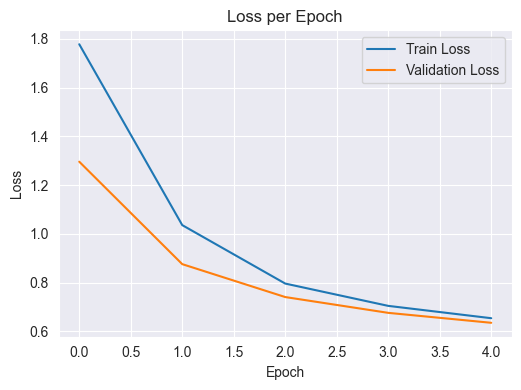

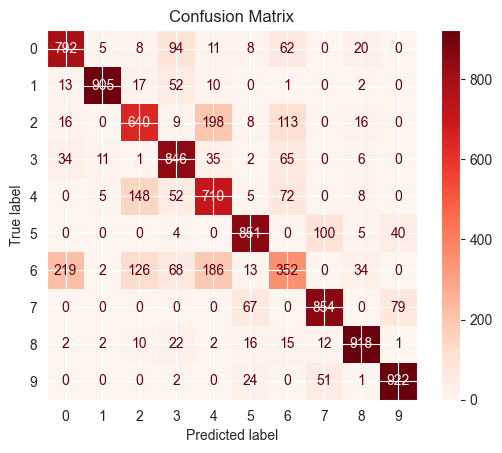

Test Loss: 0.6507, Test Accuracy: 77.90%


In [4]:
baseline_model =  BaselineCNN().to(device)
    
criterion = nn.CrossEntropyLoss()   # loss function
optimizer = torch.optim.SGD(baseline_model.parameters()) # optimizer

best_baseline_model = train(baseline_model, criterion, optimizer)
test(best_baseline_model, criterion, optimizer)


## Modification 1: Adding a Second Layer

Epoch [1/5] - Train Loss: 2.1648, Train Accuracy: 35.10% - Val Loss: 1.8961, Val Accuracy: 49.60%
Epoch [2/5] - Train Loss: 1.3882, Train Accuracy: 60.59% - Val Loss: 1.0248, Val Accuracy: 64.98%
Epoch [3/5] - Train Loss: 0.8977, Train Accuracy: 69.46% - Val Loss: 0.8193, Val Accuracy: 71.91%
Epoch [4/5] - Train Loss: 0.7740, Train Accuracy: 73.34% - Val Loss: 0.7565, Val Accuracy: 73.29%
Epoch [5/5] - Train Loss: 0.7151, Train Accuracy: 75.32% - Val Loss: 0.6997, Val Accuracy: 76.19%
Best model: epoch 5


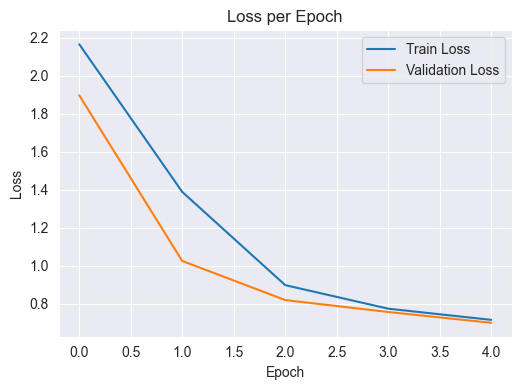

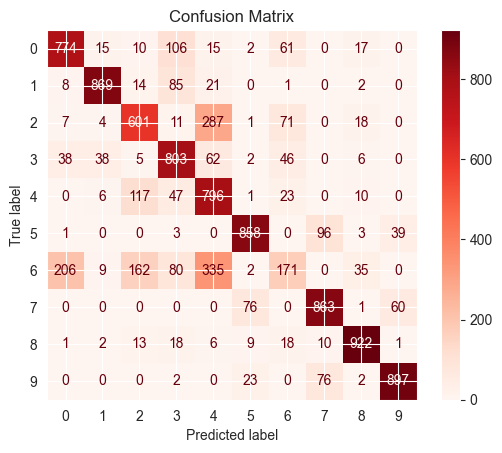

Test Loss: 0.7174, Test Accuracy: 75.54%


In [5]:
class TwoLayerCNN(CNN):
    def __init__(self, kernel_size=3, out_channels=32):
        """
        Create a Two Layer CNN model
        
        :param kernel_size: size of the sliding window the conv layer uses to scan the image (default: 3) - standard
        :param out_channels: Number of kernel filters to use (default: 32) - not to overfit early on
        """
        super(TwoLayerCNN, self).__init__()
        # create first layer
        self.conv1 = nn.Conv2d(
            in_channels=1,              # dataset is grayscale, so only 1 channel
            out_channels=out_channels,  # Number of kernel filters to use
            kernel_size=kernel_size,    # n x n size of kernel filter
            padding=kernel_size // 2    # preserve spatial dimensions
        )
        
        # create second layer
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,   # previous layer has 32 out channels
            out_channels=out_channels,  # Number of kernel filters to use
            kernel_size=kernel_size,    # n x n size of kernel filter
            padding=kernel_size // 2    # preserve spatial dimensions
        )
        
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel and stride of 2
        # fully connected layer
        # n filters x image size / 2 (pooling) / 2 (2nn pooling) x image size / 2 (pooling) / 2 (2nn pooling), 10 possible classes for FashionMNIST
        self.fc1 = nn.Linear(out_channels * 7 * 7, 10)  
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # apply pool to actuation function for first conv layer
        x = self.pool(F.relu(self.conv2(x)))    # apply pool to actuation function for 2nd conv layer
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))  # Flatten
        x = self.fc1(x)
        return x


two_layer_model =  TwoLayerCNN().to(device)
    
criterion = nn.CrossEntropyLoss()   # loss function
optimizer = torch.optim.SGD(two_layer_model.parameters()) # optimizer

best_two_layer_model = train(two_layer_model, criterion, optimizer)
test(best_two_layer_model, criterion, optimizer)

## Modification 2: Changing the Filter Size

Epoch [1/5] - Train Loss: 2.3180, Train Accuracy: 8.78% - Val Loss: 2.3186, Val Accuracy: 8.82%
Epoch [2/5] - Train Loss: 2.3180, Train Accuracy: 8.78% - Val Loss: 2.3186, Val Accuracy: 8.82%
Epoch [3/5] - Train Loss: 2.3180, Train Accuracy: 8.78% - Val Loss: 2.3186, Val Accuracy: 8.82%
Epoch [4/5] - Train Loss: 2.3180, Train Accuracy: 8.78% - Val Loss: 2.3186, Val Accuracy: 8.82%
Epoch [5/5] - Train Loss: 2.3180, Train Accuracy: 8.78% - Val Loss: 2.3186, Val Accuracy: 8.82%
Best model: epoch 3


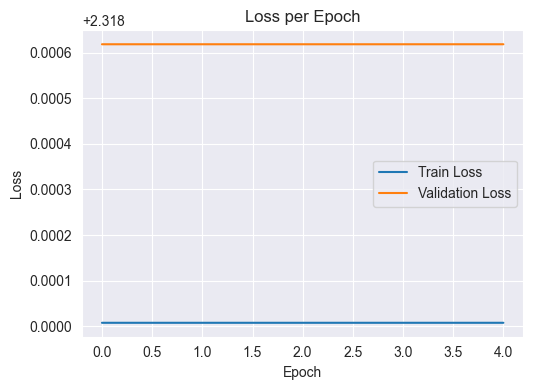

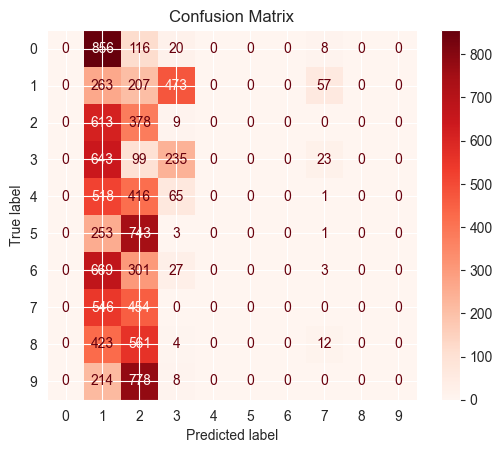

Test Loss: 2.3196, Test Accuracy: 8.76%


In [6]:
larger_filter_model =  BaselineCNN(kernel_size=5).to(device)
    
criterion = nn.CrossEntropyLoss()   # loss function
optimizer = torch.optim.SGD(two_layer_model.parameters()) # optimizer

best_larger_filter_model = train(larger_filter_model, criterion, optimizer)
test(best_larger_filter_model, criterion, optimizer)